# Imports

In [1]:
!nvidia-smi

Sat Mar 12 19:50:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt

tf.__version__, tfp.__version__

('2.8.0', '0.16.0')

# Reparameterization Layers

In [3]:
# divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / total_samples

# tfpl.Convolution2DReparameterization(
#         input_shape = (128,6), 
#         filters = 8, 
#         kernel_size = 16,
#         activation = 'relu',
#         kernel_prior_fn = tfpl.default_multivariate_normal_fn,
#         kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
#         kernel_divergence_fn = divergence_fn,
#         bias_prior_fn = None,
#         bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=True),
#         bias_divergence_fn = divergence_fn)

## Load MNIST Data

In [4]:
train_ds, test_ds = tfds.load('mnist',
                              split = ['train', 'test'],
                              as_supervised = True)

# Normalize and one-hot
def ohe_normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.divide(images, 255.0)

    labels = tf.one_hot(labels, 10)

    return images, labels

train_ds = train_ds.batch(128).map(ohe_normalize).shuffle(128) \
          .prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).map(ohe_normalize) \
          .prefetch(tf.data.AUTOTUNE)

# Outputs a tuple of two elements, first --> Images, second --> Labels
train_ds.element_spec          

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

## First Normal CNN

In [ ]:
normal_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation = 'swish', 
                           input_shape = (28, 28, 1),
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(32, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.GlobalMaxPooling2D(),
    
    tf.keras.layers.Dense(10, activation = 'softmax')
])

normal_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
             metrics = ['acc'])

normal_cnn.summary() # Total params: 98,442

## Bayesian CNN

In [6]:
# Revise reinterpreted_batch_ndims arg. Needed for custom prior & posterior.
shape = (4, )
dtype = tf.float32
distribution = tfd.Normal(loc = tf.zeros(shape, dtype),
                            scale = tf.ones(shape, dtype))
# batch_ndims = tf.size(distribution.batch_shape_tensor())

for i in range(len(shape) + 1):
    print('reinterpreted_batch_ndims: %d:' %(i))
    independent_dist = tfd.Independent(distribution,
                                       reinterpreted_batch_ndims = i)
    samples = independent_dist.sample()
    print('batch_shape: {}' 
          ' event_shape: {}' 
          ' Sample shape: {}'.format(independent_dist._batch_shape(),
                                    independent_dist._event_shape(),
                                    samples.shape))
    print('Samples:', samples.numpy(), '\n')

reinterpreted_batch_ndims: 0:
batch_shape: (4,) event_shape: () Sample shape: (4,)
Samples: [-1.4488162   0.28503537 -2.6792827   1.6637591 ] 

reinterpreted_batch_ndims: 1:
batch_shape: () event_shape: (4,) Sample shape: (4,)
Samples: [-0.59052044  0.00105313 -0.59601015  0.643041  ] 



### How to Provide Custom Prior?

In [7]:
# For Reparameterization Layers
def custom_mvn_prior(dtype, shape, name, trainable, add_variable_fn):
    distribution = tfd.Normal(loc = 0.1 * tf.ones(shape, dtype),
                              scale = 0.003 * tf.ones(shape, dtype))
    batch_ndims = tf.size(distribution.batch_shape_tensor())
    
    independent_distribution = tfd.Independent(distribution,
                                   reinterpreted_batch_ndims = batch_ndims)
    return independent_distribution

### What if KL cannot be Computed Analytically?

In [8]:
# The default posterior is Normal and if we use a laplace prior, we need to
# approximate the KL. If we try to compute KL with that 2 distributions, we will get:
# Error:
# No KL(distribution_a || distribution_b) registered for distribution_a type Normal and distribution_b type Laplace

# Call arguments received:
#   • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)

def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

total_samples = 60000
divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, q_tensor) / total_samples

In [9]:
def conv_reparameterization_layer(filters, kernel_size, activation):
    # For simplicity, we use default prior and posterior.
    # In the next parts, we will use custom mixture prior and posteriors.
    return tfpl.Convolution2DReparameterization(
            filters = filters,
            kernel_size = kernel_size,
            activation = activation, 
            padding = 'same',
            kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_prior_fn = tfpl.default_multivariate_normal_fn,
            
            bias_prior_fn = tfpl.default_multivariate_normal_fn,
            bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
            
            kernel_divergence_fn = divergence_fn,
            bias_divergence_fn = divergence_fn)

### Create BCNN

In [10]:
bayesian_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer((28, 28, 1)),
    
    conv_reparameterization_layer(16, 3, 'swish'),
    tf.keras.layers.MaxPooling2D(2),
    
    conv_reparameterization_layer(32, 3, 'swish'),
    tf.keras.layers.MaxPooling2D(2),

    conv_reparameterization_layer(64, 3, 'swish'),
    tf.keras.layers.MaxPooling2D(2),

    conv_reparameterization_layer(128, 3, 'swish'),
    tf.keras.layers.GlobalMaxPooling2D(),
    
    tfpl.DenseReparameterization(
        units = tfpl.OneHotCategorical.params_size(10), activation = None,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        
        kernel_divergence_fn = divergence_fn,
        bias_divergence_fn = divergence_fn),
    tfpl.OneHotCategorical(10)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

bayesian_cnn.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

bayesian_cnn.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 28, 28, 16)       320       
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_reparameterization_1  (None, 14, 14, 32)       9280      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_reparameterization_2  (None, 7, 7, 64)        

In [11]:
bayesian_cnn.fit(train_ds, epochs = 12, validation_data = test_ds)

Epoch 1/12
469/469 [==============================] - 17s 18ms/step - loss: 4.7674 - accuracy: 0.6792 - val_loss: 4.1597 - val_accuracy: 0.9095
Epoch 2/12
469/469 [==============================] - 5s 11ms/step - loss: 4.0503 - accuracy: 0.9244 - val_loss: 3.9239 - val_accuracy: 0.9428
Epoch 3/12
469/469 [==============================] - 5s 11ms/step - loss: 3.8208 - accuracy: 0.9484 - val_loss: 3.7356 - val_accuracy: 0.9456
Epoch 4/12
469/469 [==============================] - 5s 11ms/step - loss: 3.6138 - accuracy: 0.9596 - val_loss: 3.5012 - val_accuracy: 0.9679
Epoch 5/12
469/469 [==============================] - 5s 11ms/step - loss: 3.4163 - accuracy: 0.9673 - val_loss: 3.3117 - val_accuracy: 0.9726
Epoch 6/12
469/469 [==============================] - 5s 11ms/step - loss: 3.2263 - accuracy: 0.9712 - val_loss: 3.1341 - val_accuracy: 0.9744
Epoch 7/12
469/469 [==============================] - 5s 11ms/step - loss: 3.0467 - accuracy: 0.9740 - val_loss: 2.9602 - val_accuracy: 0.975

In [12]:
example_images = []
example_labels = []

for x, y in test_ds.take(10):
    example_images.append(x.numpy())
    example_labels.append(y.numpy())

example_images = np.concatenate(example_images, axis = 0)    
example_labels = np.concatenate(example_labels, axis = 0)    

In [13]:
def analyse_model_prediction(image, label = None, forward_passes = 10):
    if label is not None:
        label = np.argmax(label, axis = -1)
    
    extracted_probabilities = np.empty(shape=(forward_passes, 10))
    extracted_std = np.empty(shape=(forward_passes, 10))
    for i in range(forward_passes):
        model_output_distribution = bayesian_cnn(tf.expand_dims(image, 
                                                  axis = 0))
        extracted_probabilities[i] = model_output_distribution.mean().numpy().flatten()
        extracted_std[i] = model_output_distribution.stddev().numpy().flatten()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6),
                                   gridspec_kw={'width_ratios': [2, 4]})
    plt.xticks(fontsize = 16, rotation = 45)
    plt.yticks(fontsize = 16)

    # Show the image and the true label if provided.
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.axis('off')
    if label is not None:
        ax1.set_title('True Label: {}'.format(str(label)), fontsize = 20)
    else:
        ax1.set_title('True Label Not Given', fontsize = 20)
    
    # Obtain the 95% prediction interval.
    # extracted_probabilities.shape = (forward_passes, 10)
    # So if we sample from the model 100 times, there will be 100 different
    # values for each of the 10 classes. 
    # We get the interval for each of the classes independently.
    pct_2p5 = np.array([np.percentile(extracted_probabilities[:, i], 
                                      2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(extracted_probabilities[:, i], 
                                       97.5) for i in range(10)]) 

    # Std also contains 100 different values. We take median across the column
    # to obtain a single value for each of the class label.
    extracted_std = np.median(extracted_std, axis = 0)
    highest_var_label = np.argmax(extracted_std, axis = -1)
    if label is not None:
        print('Label %d has the highest std in this'
        ' prediction with the value %.3f' %(highest_var_label,
                                            extracted_std[highest_var_label]))
    else:
      print('Std Array:', extracted_std)     
    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    if label is not None:
        bar[int(label)].set_color('green')
    
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', 
            linewidth=4, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability', fontsize = 18)
    ax2.set_title("Model's Probabilities", fontsize = 20)
    plt.show()

Label 8 has the highest std in this prediction with the value 0.157


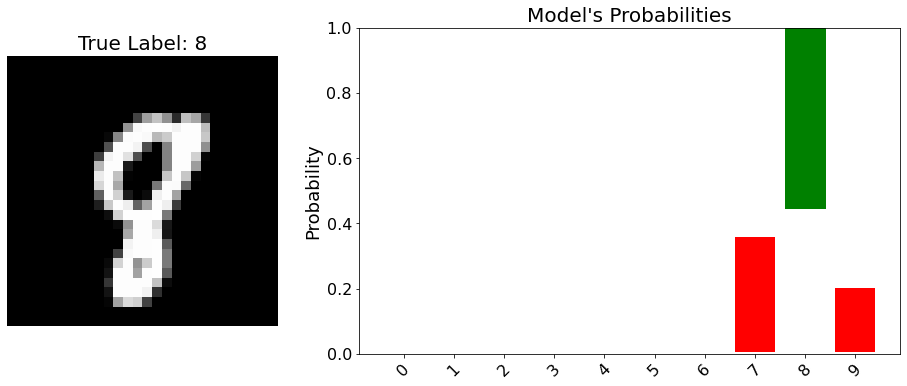

In [18]:
analyse_model_prediction(example_images[284], example_labels[284])

Label 0 has the highest std in this prediction with the value 0.001


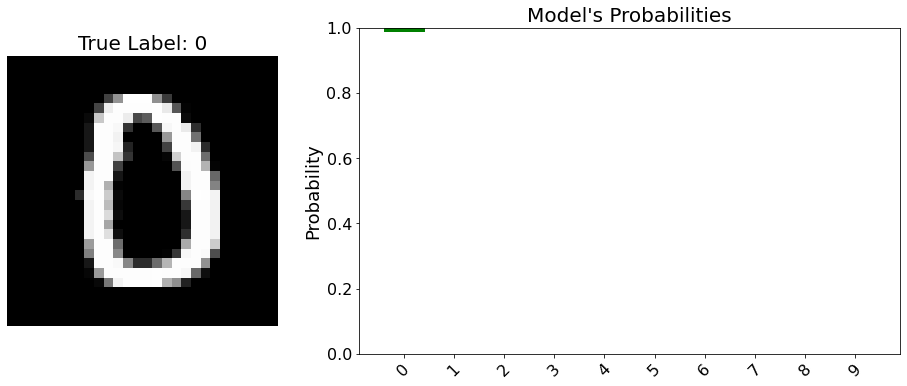

In [14]:
analyse_model_prediction(example_images[50], example_labels[50])

Label 0 has the highest std in this prediction with the value 0.278


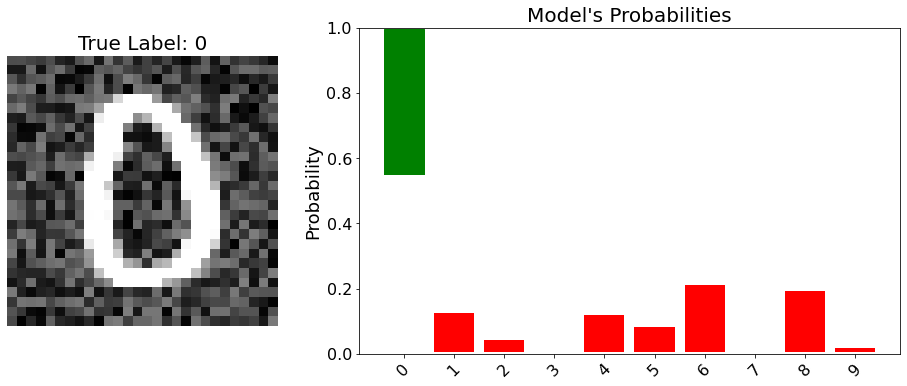

In [15]:
noise_vector = np.random.uniform(size = (28, 28, 1), low = 0, high = 0.5)
noisy_image = np.clip(example_images[50] + noise_vector, 0, 1)
analyse_model_prediction(noisy_image, example_labels[50])

Label 0 has the highest std in this prediction with the value 0.434


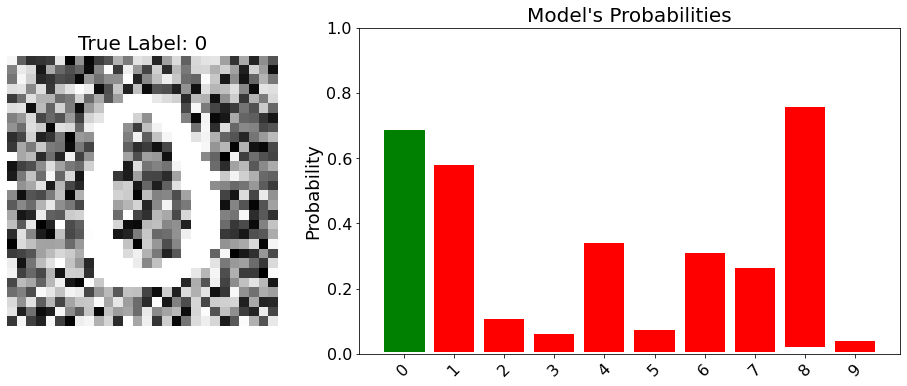

In [16]:
noise_vector = np.random.uniform(size = (28, 28, 1), low = 0, high = 0.5)
noisy_image = np.clip(example_images[50] + noise_vector*2, 0, 1)
analyse_model_prediction(noisy_image, example_labels[50])

Std Array: [0.27027504 0.22355586 0.19433676 0.08276099 0.1712302  0.14369398
 0.31018993 0.13080781 0.47434729 0.18379491]


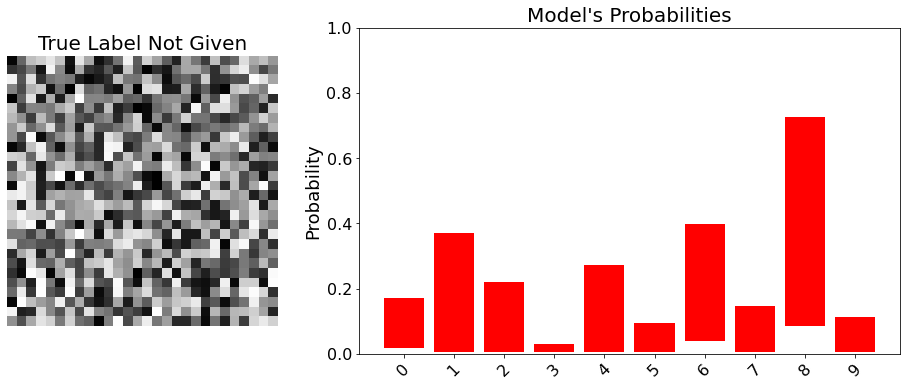

In [17]:
analyse_model_prediction(np.random.uniform(size = (28, 28, 1), low = 0, 
                                           high = 1))